 - Prepare Data for Modeling

In [1]:
import yfinance as yf

tickers = ['BND','SPY','TSLA']
data = yf.download(tickers, start="2015-01-01", end="2026-01-15")['Close']

# Flatten MultiIndex if needed
adj_close = data.copy()
tsla = adj_close['TSLA']




[*********************100%***********************]  3 of 3 completed


In [2]:
import pandas as pd

# Load processed TSLA data
tsla = adj_close['TSLA']

# Split chronologically
train = tsla['2015-01-01':'2024-12-31']
test = tsla['2025-01-01':'2026-01-15']

print(f"Train length: {len(train)}, Test length: {len(test)}")


Train length: 2516, Test length: 259


- ARIMA/SARIMA Model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16374.056, Time=4.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16368.573, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16370.458, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16370.460, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16368.109, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16372.458, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.983 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2516
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8183.054
Date:                Tue, 27 Jan 2026   AIC                          16368.109
Time:                        09:12:28   BIC                          16373.939
Sample:                             0   HQIC                         16370.225
    

c:\Users\bezis\anaconda3\envs\portfolio-opt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\bezis\anaconda3\envs\portfolio-opt\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


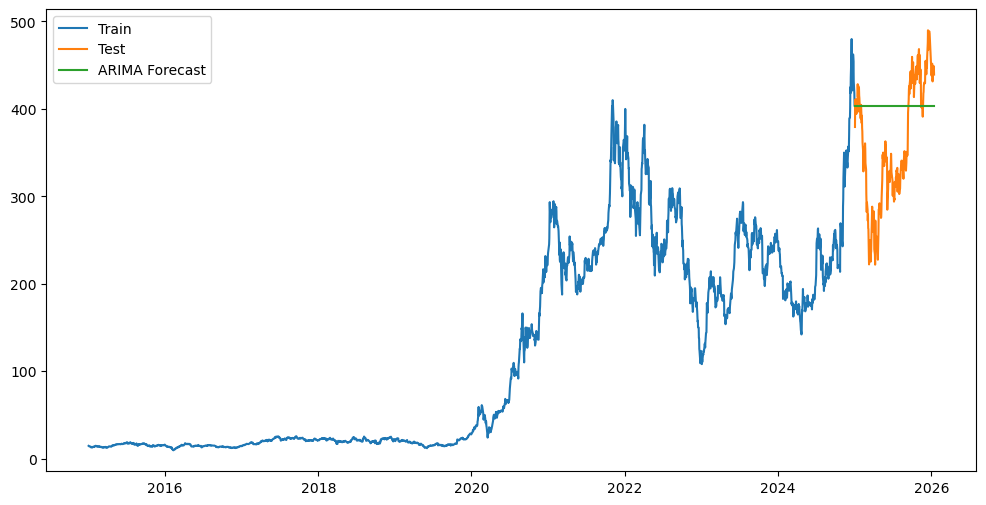

In [3]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Find optimal ARIMA parameters
model_arima = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

print(model_arima.summary())

# Forecast
n_periods = len(test)
forecast_arima = model_arima.predict(n_periods=n_periods)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.legend()
plt.show()


- LSTM Model


c:\Users\bezis\anaconda3\envs\portfolio-opt\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.9203e-04 - val_loss: 0.0035
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 7.9970e-04 - val_loss: 0.0034
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 8.0965e-04 - val_loss: 0.0021
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.6574e-04 - val_loss: 0.0023
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 6.5837e-04 - val_loss: 0.0017
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.1972e-04 - val_loss: 0.0016
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.4970e-04 - val_loss: 0.0015
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 4.3737e-04 - val_loss: 0.0013
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.0720e-04 - val_loss: 0.0015
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.7952e-04 - val_loss: 0.0013
Epoch 12/20
70/70 ━━━━━

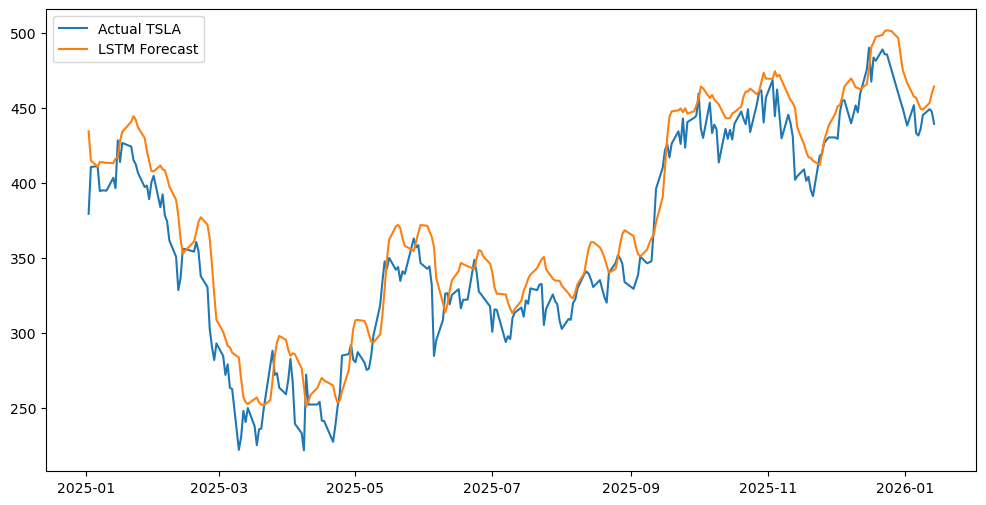

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train.values.reshape(-1,1))
scaled_test = scaler.transform(test.values.reshape(-1,1))

# Prepare sequences
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train)
X_test, y_test = create_sequences(np.concatenate((scaled_train[-60:], scaled_test), axis=0))

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    LSTM(50),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Forecast
pred_lstm = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)

# Plot
plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, label='Actual TSLA')
plt.plot(test.index, pred_lstm, label='LSTM Forecast')
plt.legend()
plt.show()


- Evaluate Models

In [10]:
# ARIMA metrics
mae_arima = mean_absolute_error(test_flat, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test_flat, forecast_arima))
mape_arima = mape(test_flat, forecast_arima)

# LSTM metrics
mae_lstm = mean_absolute_error(test_flat, pred_lstm_flat)
rmse_lstm = np.sqrt(mean_squared_error(test_flat, pred_lstm_flat))
mape_lstm = mape(test_flat, pred_lstm_flat)

# Comparison table
comparison = pd.DataFrame({
    'MAE':[mae_arima, mae_lstm],
    'RMSE':[rmse_arima, rmse_lstm],
    'MAPE':[mape_arima, mape_lstm]
}, index=['ARIMA', 'LSTM'])

print(comparison)


             MAE       RMSE       MAPE
ARIMA  69.498957  82.934613  22.557915
LSTM   18.797642  22.650307   5.624353


# Model Comparison – Tesla Stock Price Forecasting

| Model | MAE   | RMSE  | MAPE (%) |
|-------|-------|-------|-----------|
| ARIMA | 69.50 | 82.93 | 22.56     |
| LSTM  | 18.80 | 22.65 | 5.62      |

## Insights

### Accuracy
- The **LSTM model** clearly outperforms ARIMA on all metrics:  
  - **MAE** reduced from ~69.5 to ~18.8 → LSTM predicts Tesla prices closer to the true values.  
  - **RMSE** reduced from ~82.9 to ~22.7 → LSTM handles large price swings better.  
  - **MAPE** dropped from 22.6% to 5.6% → LSTM has lower relative error.

### Reasoning
- Tesla stock is highly **volatile** and exhibits **non-linear patterns** (big spikes and drops).  
- **ARIMA**, a linear model, struggles with extreme price swings and non-linear trends.  
- **LSTM**, a deep learning model, can capture **complex temporal dependencies** and volatility patterns, which explains its superior performance.

### Recommendation
- For **short-term forecasting** of Tesla stock prices, **LSTM is preferred**.  
- ARIMA could still be useful for **simpler and more interpretable models**, especially in situations with **moderate volatility**.
